#### Advanced preprocessing
- stop-words removal
- URLs replaced with domain names

#### Basic transformation
- no dimensionality reduction
- tf-idf normalization

#### Random Forest
- no parameter tuning
- default parameters
- OvR approach using OneVsRestClassifier

In [1]:
import nltk
import numpy as np
import pandas as pd
import re
import sklearn
import urllib.request as req

from django.core.validators import URLValidator
from django.core.exceptions import ValidationError

from nltk import WordNetLemmatizer
from nltk import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve

from scipy.stats import expon
from scipy.stats import randint as sp_randint

from urllib.parse import urlparse
from tldextract import extract

import warnings
warnings.filterwarnings('ignore')

# 1. Load data

In [2]:
df = pd.read_csv('../mbti_1.csv')

### Preprocessing

In [3]:
df['posts'] = df['posts'].replace(to_replace="\|\|\|", value=" ", regex=True)
df['posts'] = df['posts'].str[1:-1]

In [4]:
df['type'] = df['type'].replace(to_replace="ESTP", value="ES*")
df['type'] = df['type'].replace(to_replace="ESFP", value="ES*")
df['type'] = df['type'].replace(to_replace="ESFJ", value="ES*")
df['type'] = df['type'].replace(to_replace="ESTJ", value="ES*")

In [5]:
df.head()

,type,posts
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw htt...
1,ENTP,I'm finding the lack of me in these posts very...
2,INTP,Good one _____ https://www.youtube.com/watc...
3,INTJ,"Dear INTP, I enjoyed our conversation the ot..."
4,ENTJ,You're fired. That's another silly misconcepti...


In [6]:
# Replace URLs with domain names
for index, row in df.iterrows():
    urls = re.findall('(?P<url>https?://[^\s]+)', row['posts'])
    for u in urls:
        row['posts'] = row['posts'].replace(u, extract(u).domain)

In [7]:
# Remove non-alfa-num chars with exceptions (?!-)
df['posts'] = df['posts'].replace(r'[^0-9a-zA-Z?!-]+', ' ', regex=True)

In [8]:
# Reduce multiple dashes to one
df['posts'] = df['posts'].replace(r'\-+', '-', regex=True)

In [9]:
# Remove dashes from beginning and end of every string
df['posts'] = df['posts'].replace(r'(^-+)|(-+$)', '', regex=True)

# 2. Train - Test split

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
X_train = train['posts'].values
X_test = test['posts'].values
Y_train = train['type'].values
Y_test = test['type'].values

In [12]:
X_train.size

6940

# 3. Encoding labels

In [13]:
le = LabelEncoder()
le.fit(Y_train)

LabelEncoder()

In [14]:
le.classes_

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ES*', 'INFJ', 'INFP', 'INTJ',
       'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], dtype=object)

In [15]:
y_train_enc = le.transform(Y_train)
y_train_enc

array([5, 1, 3, ..., 5, 6, 7])

# 4. Classification pipeline
### with feature extraction and tf-idf

In [18]:
def get_wordnet_pos(treebank_tag):
    """
    Maps treebank tags to wordnet.
    This step is needed when doing lemmatization
    in combination with pos tagging.
    :return: corresponding wordnet tag object
    """
    # Decision block for mapping treebank tags to wordnet.
    # Source: http://stackoverflow.com/a/15590384/5491423
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [19]:
class LemmaTokenizer(object):
    """
    Based on: http://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes
    """
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t, get_wordnet_pos(pt)) for t, pt in nltk.pos_tag(word_tokenize(doc))]


class StemTokenizer(object):
    """
    Based on: http://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes
    """
    def __init__(self):
        self.ps = PorterStemmer()

    def __call__(self, doc):
        return [self.ps.stem(t) for t in word_tokenize(doc)]

In [20]:
# RF Pipeline
def create_rf_pipe(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=10,
                   norm='l2'):
            
    rf_classifier = Pipeline([
        ('vectorizer', CountVectorizer(lowercase=True, 
                                       tokenizer=LemmaTokenizer(),
                                       # tokenizer=StemTokenizer(), 
                                       stop_words='english'
                                        )),
        ('tfidf', TfidfTransformer(norm=norm)),
        ('clf', RandomForestClassifier(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf,
                                       min_samples_split=min_samples_split, n_estimators=n_estimators, 
                                       class_weight='balanced', verbose=100, random_state=42, n_jobs=-1))
    ])
    return rf_classifier

# 5. Training

In [29]:
rf_params = {'tfidf__norm': ['l1','l2'],
             'clf__max_depth': [50, 200, None],
             'clf__max_features': ['sqrt', 300],
             'clf__min_samples_leaf': [1, 2, 4],
             'clf__min_samples_split': [2, 5, 10],
             'clf__n_estimators': [50, 100, 200, 500]}

n_iter = 5
cv = KFold(n_splits=2, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(create_rf_pipe(), 
                                   verbose=50,
                                   param_distributions=rf_params,
                                   n_iter=n_iter, 
                                   cv=cv, n_jobs=-1, 
                                   scoring='f1_weighted')

random_search.fit(X_train, y_train_enc)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] tfidf__norm=l2, clf__n_estimators=100, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=None 
[CV] tfidf__norm=l2, clf__n_estimators=100, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=None 
[CV] tfidf__norm=l1, clf__n_estimators=100, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=200 
[CV] tfidf__norm=l1, clf__n_estimators=100, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=200 
building tree 1 of 100
building tree 4 of 100
building tree 2 of 100
building tree 3 of 100
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
building tree 5 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
building tree 6 of 100
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
building tree 7 of 100
[Parallel(n_jobs=-1)]: Done   4 t

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
building tree 6 of 100
building tree 7 of 100
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.4s
building tree 90 of 100
building tree 91 of 100
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    5.5s
building tree 92 of 100
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.6s
building tree 8 of 100
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    5.6s
building tree 93 of 100
building tree 9 of 100
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
building tree 10 of 100
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.9s
building tree 96 of 100
building tree 94 of 100
building tree 11 of 100
[Parallel(n_jobs=-1)]: Done  91 ta

building tree 49 of 100
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.5s
building tree 50 of 100
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    3.5s
building tree 45 of 100
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
building tree 46 of 100
building tree 51 of 100
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    3.6s
building tree 47 of 100
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.7s
building tree 48 of 100
building tree 52 of 100
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    4.9s
building tree 49 of 100
building tree 53 of 100
building tree 50 of 100
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 

building tree 11 of 100
building tree 88 of 100
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    8.5s
building tree 89 of 100
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    8.5s
building tree 90 of 100
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
building tree 12 of 100
building tree 94 of 100
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    7.7s
building tree 96 of 100
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
building tree 95 of 100
building tree 91 of 100
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    8.8s
building tree 13 of 100
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
building tree 97 of 100
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    7.7s
building tree 15 of 100
[Parallel(n_jobs=-1)]: Done  1

building tree 86 of 100
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    7.1s
building tree 87 of 100
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    7.2s
building tree 88 of 100
building tree 89 of 100
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    7.4s
building tree 90 of 100
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    7.4s
building tree 91 of 100
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.5s
building tree 92 of 100
building tree 93 of 100
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    7.6s
building tree 94 of 100
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:    7.7s
building tree 95 of 100
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    7.7s
building tree 96 of 100
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed: 

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  55 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  61 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  63 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  66 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  67 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  70 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  95 out of 100 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  97 out of 100 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  12 tasks  

[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  81 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  55 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  82 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  83 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  84 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  85 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  86 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  87 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  61 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  63 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  65 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  66 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  67 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  70 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  73 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  75 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  95 out of 100 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  97 out of 100 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished
[CV]  tfidf__norm=l2, clf__n_estimators=100, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=None, score=0.5226770180888676, total=20.3min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed: 31.7min remaining: 47.5min
[CV] tfidf__norm=l2, clf__n_estimators=50, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=300, clf__max_depth=200 
building tree 4 of 50
building tree 3 of 50
building tree 2 of 50
building tree 1 of 50
building tree 5 of 50
building tree 6 of 50
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
building tree 7 of 50
[Parallel(n_jobs=-1)]: Done   2

[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    4.0s
building tree 40 of 500
building tree 41 of 500
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    4.0s
building tree 42 of 500
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    4.1s
building tree 43 of 500
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.3s
building tree 44 of 500
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    4.3s
building tree 45 of 500
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
building tree 46 of 500
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    4.5s
building tree 47 of 500
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    4.6s
building tree 48 of 500
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.8s
building tree 49 of 500
building tree 50 of 500
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed: 

building tree 135 of 500
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   13.3s
building tree 136 of 500
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   13.4s
building tree 137 of 500
building tree 138 of 500
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   13.4s
building tree 139 of 500
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   13.6s
building tree 140 of 500
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   13.7s
building tree 141 of 500
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.9s
building tree 142 of 500
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   14.0s
building tree 143 of 500
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   14.0s
building tree 144 of 500
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   14.1s
building tree 145 of 500
[Parallel(n_jobs=-1)]: Done 142 tasks      

building tree 12 of 50
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
building tree 222 of 500
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 219 tasks      | elapsed:   22.4s
building tree 223 of 500
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
building tree 13 of 50
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
building tree 14 of 50
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.4s
building tree 15 of 50
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:   22.6s
building tree 224 of 500
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:   22.7s
building tree 225 of 500
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.7s
building tree 16 of 50
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.7s
building tree 17 of 50
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s
building tree 18 of 50
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:   2

[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:   29.3s
building tree 274 of 500
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   29.5s
building tree 275 of 500
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   29.5s
building tree 276 of 500
building tree 277 of 500
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   29.6s
building tree 278 of 500
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:   29.8s
building tree 279 of 500
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   29.9s
building tree 280 of 500
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:   30.0s
building tree 282 of 500
building tree 281 of 500
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:   30.2s
building tree 283 of 500
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   30.4s
building tree 284 of 500
[Parallel(n_jobs=-1)]: Done 281 tasks      

building tree 44 of 500
building tree 328 of 500
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:   36.5s
building tree 329 of 500
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    6.0s
building tree 45 of 500
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed:   36.6s
building tree 330 of 500
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
building tree 46 of 500
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    6.1s
building tree 47 of 500
[Parallel(n_jobs=-1)]: Done 327 tasks      | elapsed:   36.9s
building tree 331 of 500
building tree 48 of 500
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    6.5s
building tree 49 of 500
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:   37.2s
building tree 332 of 500
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.6s
building tree 50 of 500
[Parallel(n_jobs=-1)]: Do

building tree 92 of 500
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 371 tasks      | elapsed:   43.2s
building tree 375 of 500
building tree 93 of 500
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.7s
building tree 94 of 500
building tree 376 of 500
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   12.8s
building tree 95 of 500
building tree 377 of 500
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 374 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   13.1s
building tree 96 of 500
building tree 378 of 500
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   13.1s
building tree 97 of 500
building tree 379 of 500
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   13.3s
building tree 98 of 500
[Parallel(n_jobs=-1)]: Do

[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed:   49.7s
building tree 419 of 500
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   19.2s
building tree 143 of 500
building tree 420 of 500
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   19.2s
building tree 144 of 500
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   49.7s
building tree 421 of 500
[Parallel(n_jobs=-1)]: Done 417 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   19.4s
building tree 145 of 500
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   19.5s
building tree 146 of 500
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.2s
building tree 423 of 500
[Parallel(n_jobs=-1)]: Done 419 tasks      | elapsed:   50.2s
building tree 422 of 500
building tree 147 of 500
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:   50.3s
building tree 424 of 500
building tree 148 of 500
[Parallel(n_jobs=-

[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 463 tasks      | elapsed:   56.2s
building tree 467 of 500
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   56.3s
building tree 468 of 500
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   25.9s
building tree 190 of 500
building tree 191 of 500
[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:   25.9s
building tree 192 of 500
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:   56.6s
building tree 469 of 500
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   26.1s
building tree 193 of 500
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   56.7s
building tree 470 of 500
building tree 471 of 500
[Parallel(n_jobs=-1)]: Done 467 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   56.8s
building tree 472 of 500
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:   26.4s
buildi

[Parallel(n_jobs=-1)]: Done 247 tasks      | elapsed:   33.2s
building tree 251 of 500
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   33.2s
building tree 252 of 500
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   33.2s
building tree 253 of 500
building tree 254 of 500
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed:   33.5s
building tree 255 of 500
building tree 256 of 500
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:   33.7s
building tree 257 of 500
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:   33.8s
building tree 258 of 500
building tree 259 of 500
[Parallel(n_jobs=-1)]: Done 255 tasks      | elapsed:   34.0s
building tree 260 of 500
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   34.1s
building tree 261 of 500
building tree 262 of 500
[Parallel(n_jobs=-

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:   42.4s
building tree 346 of 500
building tree 347 of 500
[Parallel(n_jobs=-1)]: Done 343 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   42.5s
building tree 348 of 500
[Parallel(n_jobs=-1)]: Done 345 tasks      | elapsed:   42.5s
building tree 349 of 500
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:   42.8s
building tree 350 of 500
building tree 351 of 500
[Parallel(n_jobs=-1)]: Done 347 tasks      | elapsed:   42.8s
building tree 352 of 500
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   42.8s
building tree 353 of 500
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 350 tasks      | elapsed:   43.1s
building tree 354 of 500
[Parallel(n_jobs=-1)]: Done 351 tasks      | elapsed:   43.2s
building tree 355 of 500
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   43.2s
buildi

building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   51.6s
building tree 442 of 500
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   51.8s
building tree 443 of 500
[Parallel(n_jobs=-1)]: Done 439 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:   51.8s
building tree 444 of 500
building tree 445 of 500
[Parallel(n_jobs=-1)]: Done 441 tasks      | elapsed:   51.8s
building tree 446 of 500
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 443 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   52.3s
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   52.5s
building tree 450 of 500
building tree 451 

[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0

[Parallel(n_jobs=4)]: Done  81 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  82 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  83 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  84 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  85 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  86 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  87 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  89 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  91 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  94 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  95 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  96 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 216 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 217 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 218 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 219 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 220 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 221 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 222 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 223 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 224 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 225 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 226 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 227 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 228 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 229 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 230 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 231 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 351 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 352 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 353 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 354 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 355 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 356 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 358 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 359 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 360 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 361 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 362 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 363 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 364 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 365 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 366 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 486 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 487 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 489 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 490 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 491 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 492 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 493 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_job

[Parallel(n_jobs=4)]: Done 127 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 129 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 131 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 132 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 133 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 134 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 135 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 138 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 139 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 140 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 141 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 142 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 262 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 263 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 265 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 266 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 267 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 268 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 269 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 270 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 271 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 272 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 273 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 274 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 275 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 276 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 277 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 397 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 398 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 399 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 400 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 401 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 402 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 403 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 404 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 405 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 406 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 407 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 408 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 409 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 410 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 411 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 412 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  44 out of  50 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  45 out of  50 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  46 out of  50 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  47 out of  50 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  48 out of  50 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.7s finished
[CV]  tfidf__norm=l2, clf__n_estimators=50, clf__min_samples_split=10, clf__min_samp

[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  61 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  63 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  65 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  66 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  67 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  70 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 170 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 171 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 172 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 174 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 175 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 236 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  94 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 237 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  95 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 238 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  96 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 239 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  97 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 240 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 241 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  99 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 242 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 301 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 162 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 302 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 163 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 164 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 303 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 165 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 304 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 306 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 166 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 167 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 307 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 308 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 168 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 370 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 227 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 371 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 372 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 228 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 373 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 374 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 375 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 229 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 377 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 378 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 230 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 379 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 380 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 381 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 293 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 439 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 294 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 295 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 440 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 441 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 296 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 443 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 444 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 297 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 445 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 298 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 446 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 447 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 448 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 369 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 370 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 371 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 65.0min remaining: 27.9min
[Parallel(n_jobs=4)]: Done 372 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 373 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 374 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 375 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 377 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 378 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 379 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 380 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 381 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 382 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 383 tasks      | elapsed:    6.6s
[Par

building tree 6 of 50
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
building tree 7 of 50
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
building tree 8 of 50
building tree 9 of 50
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
building tree 10 of 50
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
building tree 12 of 50
building tree 11 of 50
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
building tree 13 of 50
building tree 14 of 50
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.9s
building tree 15 of 50
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.9s
building tree 16 of 50
building tree 17 of 50
[Parallel(n_jobs=-1)]: Done  13 tasks      | e

building tree 50 of 50
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    3.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  48 out of  50 | elapsed:    3.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed: 

[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Do

building tree 41 of 100[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.1s

building tree 42 of 100[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.1s

building tree 43 of 100[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    3.2s

building tree 44 of 100[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.3s

building tree 45 of 100[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    3.3s

building tree 46 of 100[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s

building tree 47 of 100[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    3.5s

building tree 48 of 100[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.6s

building tree 49 of 100[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.7s

building tree 50 of 100[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.7s

building tree 51 of 100[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    3.9s

building tree 52 of 100[Parallel(n_jobs=-1)]: Done  48

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
  ...mators=50, n_jobs=-1, oob_score=False, random_state=42,
            verbose=100, warm_start=False))]),
          fit_params=None, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'tfidf__norm': ['l1', 'l2'], 'clf__max_depth': [50, 200, None], 'clf__max_features': ['sqrt', 300], 'clf__min_samples_leaf': [1, 2, 4], 'clf__min_samples_split': [2, 5, 10], 'clf__n_estimators': [50, 100, 200, 500]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_weighted', verbose=50)

In [30]:
# Prints results of parameter tuning
df_results_rs = pd.DataFrame(random_search.cv_results_)
df_results_rs

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__max_depth,param_clf__max_features,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,param_tfidf__norm,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,610.643471,607.414828,0.533096,0.999424,None,sqrt,2,10,100,l2,"{'tfidf__norm': 'l2', 'clf__n_estimators': 100...",1,0.522677,0.999424,0.543516,0.999424,3.946676,1.498656,0.010419,4.770620e-08
1,617.396634,602.806602,0.511487,0.999856,200,sqrt,2,5,100,l1,"{'tfidf__norm': 'l1', 'clf__n_estimators': 100...",3,0.504595,1.000000,0.518379,0.999712,2.537077,0.242899,0.006892,1.438723e-04
2,733.280938,641.341671,0.519360,1.000000,200,300,1,5,500,l2,"{'tfidf__norm': 'l2', 'clf__n_estimators': 500...",2,0.510714,1.000000,0.528007,1.000000,13.584965,7.110084,0.008647,0.000000e+00
3,666.749253,659.221736,0.502214,0.999856,200,300,1,10,50,l2,"{'tfidf__norm': 'l2', 'clf__n_estimators': 50,...",4,0.502085,1.000000,0.502342,0.999712,16.039661,5.181930,0.000129,1.441059e-04
4,375.147673,404.470013,0.467558,0.999712,None,300,2,2,50,l1,"{'tfidf__norm': 'l1', 'clf__n_estimators': 50,...",5,0.449870,1.000000,0.485245,0.999424,1.838254,1.161083,0.017688,2.881175e-04


In [31]:
# Lemmatization
print(len(random_search.best_estimator_.named_steps["vectorizer"].get_feature_names()))

105116


# 6. Testing

In [32]:
predictions = random_search.predict(X_test)

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Do

In [33]:
y_test_enc = le.transform(Y_test)

In [24]:
# With OvR
precision_recall_fscore_support(y_test_enc, predictions, average='weighted')

/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.3667346323259677, 0.3792507204610951, 0.31987027707386406, None)

In [34]:
# Without OvR after parameter tunning
precision_recall_fscore_support(y_test_enc, predictions, average='weighted')

(0.5700325052613969, 0.5590778097982709, 0.5379786782877768, None)

In [35]:
print(classification_report(y_test_enc, predictions, target_names=le.classes_))

             precision    recall  f1-score   support

       ENFJ       0.57      0.10      0.17        41
       ENFP       0.61      0.55      0.58       125
       ENTJ       0.50      0.18      0.27        44
       ENTP       0.55      0.47      0.51       135
        ES*       0.56      0.14      0.22        37
       INFJ       0.54      0.59      0.56       288
       INFP       0.54      0.76      0.63       370
       INTJ       0.52      0.53      0.52       193
       INTP       0.60      0.71      0.65       293
       ISFJ       0.83      0.11      0.20        45
       ISFP       0.46      0.25      0.32        53
       ISTJ       0.80      0.27      0.41        44
       ISTP       0.67      0.43      0.53        67

avg / total       0.57      0.56      0.54      1735



In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)

In [37]:
def report_to_dataframe(report):
    report_data = []
    for i in range(2, 14):
        row_data = list(filter(None, report.split('\n')[i].split(' ')))
        print(row_data)
        df_row = {}
        df_row['trieda'] = row_data[0]
        df_row['presnosť'] = float(row_data[1])
        df_row['pokrytie'] = float(row_data[2])
        df_row['F1'] = float(row_data[3])
        df_row['podpora'] = int(row_data[4])
        
        report_data.append(df_row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe

report = classification_report(y_test_enc, predictions, target_names=le.classes_)
df_rep = report_to_dataframe(report)

['ENFJ', '0.57', '0.10', '0.17', '41']
['ENFP', '0.61', '0.55', '0.58', '125']
['ENTJ', '0.50', '0.18', '0.27', '44']
['ENTP', '0.55', '0.47', '0.51', '135']
['ES*', '0.56', '0.14', '0.22', '37']
['INFJ', '0.54', '0.59', '0.56', '288']
['INFP', '0.54', '0.76', '0.63', '370']
['INTJ', '0.52', '0.53', '0.52', '193']
['INTP', '0.60', '0.71', '0.65', '293']
['ISFJ', '0.83', '0.11', '0.20', '45']
['ISFP', '0.46', '0.25', '0.32', '53']
['ISTJ', '0.80', '0.27', '0.41', '44']


In [38]:
df_support = df_rep[['trieda', 'podpora']]
df_rep.set_index('trieda', inplace=True)
df_metrics = df_rep[['presnosť','pokrytie', 'F1']]


In [39]:
df_support = df_support.sort_values('podpora', ascending=False).reset_index(drop=True)

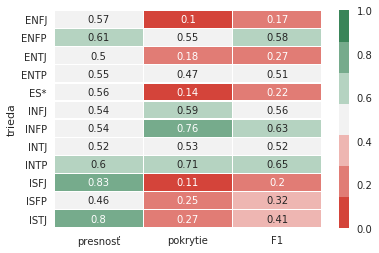

In [41]:
f, ax = plt.subplots()
color_palette = sns.diverging_palette(14, 141, sep=5, n=7)
heatmap = sns.heatmap(df_metrics, annot=True, vmin=0.0, vmax=1.0, linewidths=.4, ax=ax, cmap=color_palette)
heatfig = heatmap.get_figure()
heatfig.savefig("rf_results.png", dpi=200)

In [23]:
# Learning curves (Precision / Recall)
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


def plot_learning_curve(estimator, title, X, y, file=None, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring='f1_weighted'):
    """
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """


    plt.figure()
    plt.title(title, fontsize=14)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Trénovacie vzorky", fontsize=14)
    plt.ylabel("Skóre (" + scoring + ")", fontsize=14)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Trén. skóre")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="CV skóre"),

    plt.legend(loc=3)
    plt.savefig(file, format='png', dpi=150)
    
    return plt

In [16]:
from sklearn.externals import joblib

In [21]:
random_search = joblib.load('../rand_search_rf.pkl')

In [51]:
joblib.dump(random_search, '../rand_search_rf.pkl', compress=3)

['../rand_search_rf.pkl']

building tree 1 of 100
building tree 2 of 100
building tree 4 of 100
building tree 3 of 100
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
building tree 9 of 100
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
building tree 10 of 100
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.2s
building tree 14 of 100
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
building tree 15 of 100
building tree 16 of 100
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
build

[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
building tree 2 of 100
building tree 4 of 100
building tree 1 of 100
building tree 3 of 100
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
building tree 8 of 100
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
building tree 9 of 100
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
building tree 10 of 100
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
building tree 11 of 100
building tree 12 of 100
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.2s
building tree 13 of 100
building tree 14 of 100
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
building tree 15 of 100
[

building tree 99 of 100
building tree 98 of 100
building tree 100 of 100
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 1 of 100
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
building tree 5 of 100
building tree 6 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
building tree 7 of 100
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
building tree 9 of 100
building tree 8 of 100
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.3s
building tree 11 of 100
building tree 10 of 100
build

[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.8s
building tree 96 of 100
building tree 97 of 100
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    2.8s
building tree 98 of 100
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    2.9s remaining:    0.2s
building tree 99 of 100
building tree 100 of 100
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
building tree 2 of 100
building tree 4 of 100
building tree 1 of 100
building tree 3 of 100
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
building tree 5 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
building tree 7 of 100
building tree 6 of 100
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
building tree 8 of 100
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
building tree 9 of 100
[Para

building tree 93 of 100
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    3.7s
building tree 94 of 100
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:    3.7s
building tree 95 of 100
building tree 96 of 100
building tree 98 of 100
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.8s
building tree 97 of 100
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    3.9s remaining:    0.2s
building tree 99 of 100
building tree 100 of 100
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    4.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]:

[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  66 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  67 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  70 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  73 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  75 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  78 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  79 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  81 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Do

building tree 38 of 100
building tree 37 of 100
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.4s
building tree 39 of 100
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
building tree 40 of 100
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.5s
building tree 41 of 100
building tree 43 of 100
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.5s
building tree 42 of 100
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.5s
building tree 44 of 100
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.5s
building tree 45 of 100
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    0.5s
building tree 47 of 100
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.5s
building tree 46 of 100
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    0.5s
building tree 48 of 100
[Parallel(n_jobs=-1)]: Done  4

[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  45 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  47 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  50 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  51 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  55 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  81 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  82 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  83 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  84 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  85 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  86 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  87 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  89 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  91 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  95 out of 100 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  97 out of 100 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | ela

building tree 87 of 100
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.9s
building tree 88 of 100
building tree 89 of 100
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    6.0s
building tree 90 of 100
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    6.1s
building tree 91 of 100
building tree 92 of 100
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.2s
building tree 93 of 100
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    6.2s
building tree 94 of 100
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:    6.3s
building tree 95 of 100
building tree 96 of 100
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    6.4s
building tree 97 of 100
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    6.5s
building tree 98 of 100
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    6.6s remaining:    0.3s
building tr

building tree 85 of 100
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.2s
building tree 84 of 100
building tree 86 of 100
building tree 87 of 100
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    2.3s
building tree 89 of 100
building tree 88 of 100
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    2.3s
building tree 90 of 100
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    2.4s
building tree 91 of 100
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    2.4s
building tree 94 of 100
building tree 92 of 100
building tree 95 of 100
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    2.4s
building tree 93 of 100
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:    2.4s
building tree 96 of 100
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.5s
[Paral

[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  55 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  61 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  63 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  65 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  66 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  67 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  69 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    2.7s
building tree 70 of 100
building tree 69 of 100
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    2.8s
building tree 71 of 100
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.9s
building tree 72 of 100
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.9s
building tree 73 of 100
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    2.9s
building tree 74 of 100
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    3.0s
building tree 75 of 100
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.1s
building tree 76 of 100
building tree 78 of 100
building tree 77 of 100
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    3.1s
building tree 79 of 100
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed: 

[Parallel(n_jobs=4)]: Done  89 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  91 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  95 out of 100 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  97 out of 100 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks  

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.9s
building tree 25 of 100
building tree 26 of 100
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    1.0s
building tree 27 of 100
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
building tree 28 of 100
building tree 29 of 100
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
building tree 30 of 100
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.2s
building tree 31 of 100
building tree 32 of 100
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.2s
building tree 33 of 100
building tree 34 of 100
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.3s
building tree 35 of 100
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 

[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  66 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  67 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  70 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  73 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  75 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  78 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  79 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  81 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  47 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  51 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  55 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Do

building tree 63 of 100
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.4s
building tree 62 of 100
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    2.4s
building tree 64 of 100
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.4s
building tree 65 of 100
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    2.5s
building tree 66 of 100
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:    2.5s
building tree 67 of 100
building tree 68 of 100
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    2.6s
building tree 69 of 100
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.6s
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 

[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  81 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  82 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  83 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  84 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  85 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  86 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  87 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  89 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  91 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  95 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  97 out of 100 | elapsed:    0.6s remai

[Parallel(n_jobs=4)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  23 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Do

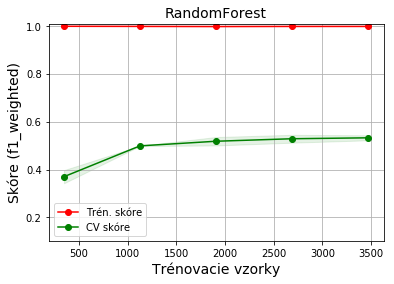

In [25]:
title = "RandomForest"
cv = KFold(n_splits=2, shuffle=True, random_state=42)
norm = random_search.best_params_.get('tfidf__norm')
max_depth = random_search.best_params_.get('clf__max_depth')
max_features = random_search.best_params_.get('clf__max_features')
min_samples_leaf = random_search.best_params_.get('clf__min_samples_leaf')
min_samples_split = random_search.best_params_.get('clf__min_samples_split')
n_estimators = random_search.best_params_.get('clf__n_estimators')

plt_p = plot_learning_curve(create_rf_pipe(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf,
                                           min_samples_split=min_samples_split, n_estimators=n_estimators, norm=norm), title, 
                            X_train, y_train_enc, ylim=(0.1, 1.01), file='f1_rf.png', 
                            cv=cv, n_jobs=-1, scoring='f1_weighted')